In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../src/")
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from process import BertProcessor
from utils import get_doc_paths, get_pickle_paths, read_labels

raw_docs_dir = "../data/raw_docs/"
labels_dir = "../data/labels/"


# Process Data

In [2]:
lang = "eng"
raw_doc_paths = get_doc_paths(raw_docs_dir, lang)
bp = BertProcessor(lang=lang, pad=False)
bp.process(raw_doc_paths)

# Create Bert Document Vectors

In [4]:
lang = "eng"
bv = BertVectorizer(lang=lang, sentence_to_doc_agg="mean")
pickle_paths = get_pickle_paths("../data/processed_bert_512_tokens_not_padded/", lang)
bv.fit(pickle_paths)
doc_vectors = bv.get_doc_vectors()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
INFO:root:Running BertVectorizer...
100%|██████████| 599/599 [68:52:12<00:00, 413.91s/it]     
INFO:root:Finished BertVectorizer.


In [5]:
df = doc_vectors.copy()
labels = read_labels(lang)
df['y'] = df["pickle_path"].apply(lambda x: labels[x.split("/")[-1][:-7]])
df['book_name'] = df['pickle_path'].apply(lambda x: x.split("/")[-1][:-7])

<ipython-input-1-7fae38c856f4>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df["file_name"][labels_df["file_name"] == key] = value


# Cross Validation

In [47]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

X = df.drop(columns=['y', 'book_name', 'pickle_path']).values
y = df["y"].values.ravel()

all_predictions = []
all_labels = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for index, (train_indices, validation_indices) in enumerate(kf.split(X)):
    train_X = X[train_indices, :]
    train_y = y[train_indices]
    validation_X = X[validation_indices, :]
    validation_y = y[validation_indices]
    pca = PCA(n_components=30)
    train_X = pca.fit_transform(train_X)
    print(pca.explained_variance_ratio_.sum())
    validation_X = pca.transform(validation_X)
    model = SVR(C=40)
    model.fit(train_X, train_y)
    train_yhat = model.predict(train_X)
    validation_yhat = model.predict(validation_X) # np.array([train_yhat.mean()] * validation_X.shape[0]) # 
    all_labels.extend(validation_y.tolist())
    all_predictions.extend(validation_yhat.tolist())
    train_mse = mean_squared_error(train_y, train_yhat)
    train_mae = mean_absolute_error(train_y, train_yhat)
    validation_mse = mean_squared_error(validation_y, validation_yhat)
    validation_mae = mean_absolute_error(validation_y, validation_yhat)
    print(f"Fold: {index+1}, TrainMSE: {train_mse}, TrainMAE: {train_mae}, ValMSE: {validation_mse}, ValMAE: {validation_mae}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

0.9028635048839946
Fold: 1, TrainMSE: 270.96905950123295, TrainMAE: 9.629039500688982, ValMSE: 514.9359734886289, ValMAE: 14.9944649697445
0.9018200643765739
Fold: 2, TrainMSE: 269.654103526607, TrainMAE: 9.382135073243429, ValMSE: 572.5430339497278, ValMAE: 18.27836027803789
0.9014533409323371
Fold: 3, TrainMSE: 275.4267311999979, TrainMAE: 9.583461493563254, ValMSE: 417.6110255447027, ValMAE: 15.979667015549056
0.8999209858096732
Fold: 4, TrainMSE: 242.12129925181225, TrainMAE: 8.960758739900415, ValMSE: 697.0814341582378, ValMAE: 20.71085712854924
0.9012847159925267
Fold: 5, TrainMSE: 272.03780226487635, TrainMAE: 9.507030088131822, ValMSE: 482.59940453940885, ValMAE: 16.488023571721886
0.9026803652143538
Fold: 6, TrainMSE: 272.01806964171396, TrainMAE: 9.622638194320983, ValMSE: 370.40097394334504, ValMAE: 14.288180280535837
0.9003243949580525
Fold: 7, TrainMSE: 275.1915235688327, TrainMAE: 9.718984683186813, ValMSE: 406.3674219661962, ValMAE: 14.162293253182272
0.9015898062598042


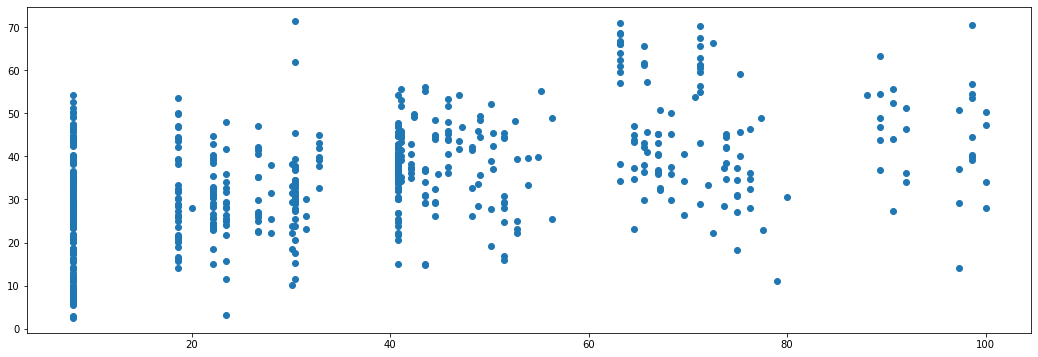

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.scatter(all_labels, all_predictions)
plt.show();